# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [186]:
# Taking all imports for processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

# TODO: code and runtime results
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# loading train-data in dataframes
train_identity_df = pd.read_csv("../data/train_identity.csv")
train_transaction_df = pd.read_csv("../data/train_transaction.csv")
global_df = pd.merge(left=train_transaction_df, right=train_identity_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
# Since Part 1 to 5 would only involve following fields
# TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2
# Loading above necessary fields into base dataframe
# And performing EDA on these data
basic_fields_df = global_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                              "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                              "addr1", "addr2", "dist1", "dist2", "isFraud", "DeviceType", "DeviceInfo"]]

In [5]:
fraudulent_df = basic_fields_df[basic_fields_df.isFraud == 1]
non_fraudulent_df = basic_fields_df[basic_fields_df.isFraud == 0]
rows_in_fraud = fraudulent_df.shape[0]
rows_in_non_fraud = non_fraudulent_df.shape[0]
total_rows = basic_fields_df.shape[0]
print("Fraudulent instances: {0} | Non Fraudulent instances: {1}".format(str(rows_in_fraud), str(rows_in_non_fraud)))

Fraudulent instances: 20663 | Non Fraudulent instances: 569877


In [6]:
# Cite: https://stackoverflow.com/questions/41681693/pandas-isnull-sum-with-column-headers

### Checking Nulls and comparing between fraudulent and non-fraudulent data-set ###

In [7]:
# isnull() returns boolean array for each row
# sum() on isnull() groups null values and take their sum returning a Series
# the Series returned has null value for each column (which can be seen as index for that value in Series)
# In the end, we take transpose() to convert index to column and corresponding row in Series to cell Value for that column
non_fraudulent_null_stats = non_fraudulent_df.isnull().sum().sort_values(ascending=False).to_frame().transpose()
percent_non_fraud_nulls = non_fraudulent_null_stats * 100.0 / rows_in_non_fraud
non_fraudulent_null_stats

,dist2,DeviceInfo,R_emaildomain,DeviceType,dist1,P_emaildomain,addr2,addr1,card4,card6,isFraud,ProductCD,TransactionAmt,TransactionDT,TransactionID
0,535981,459818,443813,440278,336363,91666,57965,57965,1536,1532,0,0,0,0,0


In [8]:
fraudulent_null_stats = fraudulent_df.isnull().sum().sort_values(ascending=False).to_frame().transpose()
percent_fraud_nulls = fraudulent_null_stats * 100.0/ rows_in_fraud
fraudulent_null_stats

,dist2,dist1,DeviceInfo,DeviceType,R_emaildomain,addr2,addr1,P_emaildomain,card4,card6,isFraud,ProductCD,TransactionAmt,TransactionDT,TransactionID
0,16932,15908,12056,9452,9436,7741,7741,2790,41,39,0,0,0,0,0


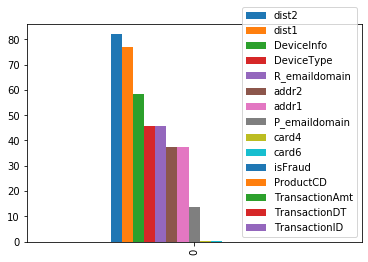

In [9]:
percent_fraud_nulls.plot.bar()

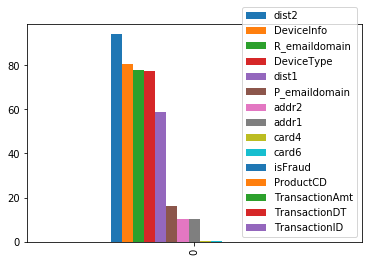

In [10]:
percent_non_fraud_nulls.plot.bar()

In [11]:
percent_fraud_nulls['tag'] = 'fraud'
percent_non_fraud_nulls['tag'] = 'non_fraud'
combined_percent_nulls = pd.concat([percent_fraud_nulls, percent_non_fraud_nulls], keys=['fraud', 'non_fraud'])
combined_percent_nulls

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,,DeviceInfo,DeviceType,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,addr1,addr2,card4,card6,dist1,dist2,isFraud,tag
fraud,0,58.345836,45.743600,13.502396,0.0,45.666167,0.0,0.0,0.0,37.463098,37.463098,0.198422,0.188743,76.987853,81.943571,0.0,fraud
non_fraud,0,80.687236,77.258426,16.085225,0.0,77.878735,0.0,0.0,0.0,10.171493,10.171493,0.269532,0.268830,59.023789,94.052050,0.0,non_fraud


## Observation from visualization around null values in Fraud transactions and Non-Fraud transactions ##
1. Just like the non-fraud transactions, majority of null values in fraud transactions are from distances, devices and email addresses.
2. The key difference is in the field of `DeviceInfo` (Windows/Mac OS), `DeviceType` (mobile, desktop), `R_emaildomain` (receipient email).
  
    a. For fraud transaction `null` values for DeviceInfo is around 58% of its set, whereas for non-fraud transactions its around 80%. 
  
    b. For fraud transaction `null` values for DeviceType is around 45% of its set, whereas for non-fraud transaction its around 77%.
  
    c. Also receipent email address are `null` for 45% of its set, whereas for non-fraud transaction its 77%.
  
 One possible explanation for above discrepancy could be: the values for above details like email address are usually not provided or deferred by benevolent transactions, but a fraudster may have provided fake values instead of ignoring like a regular transactor. This in-turn reduced `null` values for fraud transactions.

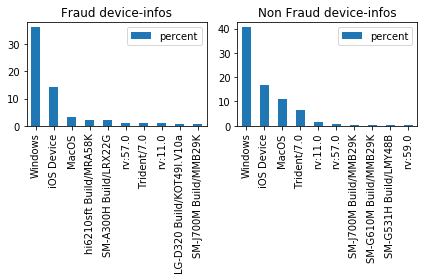

In [162]:
non_null_device_info_count_fraud = fraudulent_df.DeviceInfo.count()
non_null_device_info_count_non_fraud = non_fraudulent_df.DeviceInfo.count()

figure, axes = plt.subplots(1,2)

top_10_fraud_device_counts = fraudulent_df.DeviceInfo.value_counts().to_frame()[0:10]
top_10_fraud_device_counts = top_10_fraud_device_counts.rename(columns={"DeviceInfo": "count"})

top_10_nonfraud_device_counts = non_fraudulent_df.DeviceInfo.value_counts().to_frame()[0:10]
top_10_nonfraud_device_counts = top_10_nonfraud_device_counts.rename(columns={"DeviceInfo": "count"})

# Converting to percentages
# top10FraudDeviceInfos.count = (top10FraudDeviceInfos['count'] * 100) / non_null_device_info_count_fraud
top_10_fraud_device_counts['percent'] = top_10_fraud_device_counts['count'].apply(lambda x: (x * 100)/non_null_device_info_count_fraud)
top_10_nonfraud_device_counts['percent'] = top_10_nonfraud_device_counts['count'].apply(lambda x: (x * 100)/non_null_device_info_count_non_fraud)

top_10_fraud_device_counts.plot.bar(ax=axes[0], y='percent')
top_10_nonfraud_device_counts.plot.bar(ax=axes[1], y='percent')

axes[0].set_title("Fraud device-infos")
axes[1].set_title("Non Fraud device-infos")

plt.tight_layout()

Percentage for agent: hi6210sft Build/MRA58K, fraud: 2.091, non-fraud: 0.009
Percentage for agent: SM-A300H Build/LRX22G, fraud: 1.964, non-fraud: 0.031
Percentage for agent: LG-D320 Build/KOT49I.V10a, fraud: 0.709, non-fraud: 0.009


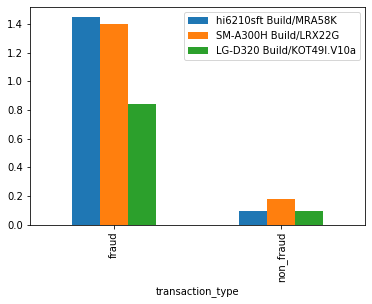

In [185]:
suspicious_device_agents = ['hi6210sft Build/MRA58K', 'SM-A300H Build/LRX22G', 'LG-D320 Build/KOT49I.V10a']
percents_in_innocent_transaction = [non_fraudulent_df[non_fraudulent_df.DeviceInfo == a].shape[0] for a in suspicious_device_agents]
percents_in_innocent_transaction = [p * 100.0 / non_null_device_info_count_non_fraud  for p in percents_in_innocent_transaction]
percents_in_innocent_transaction = [round(p, 3) for p in percents_in_innocent_transaction]

percents_in_fraud_transaction = [fraudulent_df[fraudulent_df.DeviceInfo == a].shape[0] for a in suspicious_device_agents]
percents_in_fraud_transaction = [p * 100.0 / non_null_device_info_count_fraud  for p in percents_in_fraud_transaction]
percents_in_fraud_transaction = [round(p, 3) for p in percents_in_fraud_transaction]

i = 0
df_dic = {}
df_dic['transaction_type'] = ['fraud', 'non_fraud']
for agent in suspicious_device_agents:
    df_dic[agent] = [percents_in_fraud_transaction[i], percents_in_innocent_transaction[i]]
    print("Percentage for agent: " + agent +
          ", fraud: " + str(percents_in_fraud_transaction[i]) + ", non-fraud: " + str(percents_in_innocent_transaction[i]))
    i += 1
suspicious_device_infos = pd.DataFrame(df_dic)


for agent in suspicious_device_agents:
#   Amplifying values to understand the relative scale
    suspicious_device_infos[agent] = np.sqrt(suspicious_device_infos[agent])
suspicious_device_infos.plot.bar(x='transaction_type')

### Conclusion ###
1.  We can observe that for both fraudulent and non-fraudulent transactions, device agents: Windows/iOS/MacOS have been used most frequently
2.  But, for some special devices ('hi6210sft Build/MRA58K', 'SM-A300H Build/LRX22G', 'LG-D320 Build/KOT49I.V10a') have frequency in the range of [0.7, 2] % which may not seem significant at first glance. But it is at least 70~ times more frequent than their non fraudulent counterparts [0.009, 0.031] %
3.  A quick search on this agents reveals that these are agents of mobile devices.
4.  In summary, it seems that fraudulent transactions are done more on mobile devices

### Observing distributions of fields among fraudulent and non-fraudulent transactions ###

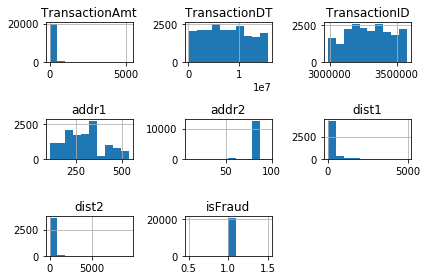

In [12]:
fraud_hists = fraudulent_df.hist()
plt.tight_layout()

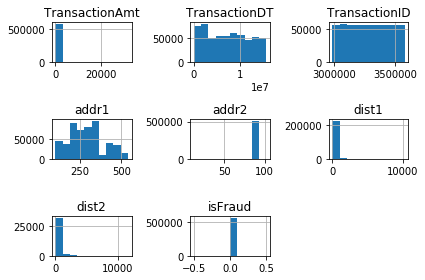

In [13]:
non_fraud_hists = non_fraudulent_df.hist()
plt.tight_layout()

## Conclusion ##
Apart from maximum frequency all histograms depict same kind of spread of values between fraudulent transactions and non-fraudulent transactions. The maximum frequency is different obviously because fraudulent transactions are only small fraction (~ 4%) of the global data-set

In [ ]:
# https://stackoverflow.com/questions/51749208/plotting-two-histograms-from-a-pandas-dataframe-in-one-subplot-using-matplotlib

## Observing max-min-std of the fields among fraud vs non-fraud transactions ##

In [ ]:
fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,2.066300e+04,2.066300e+04,20663.000000,12922.000000,12922.000000,4755.000000,3731.000000,20663.0
mean,3.294952e+06,7.690033e+06,149.244779,294.317134,86.286024,174.588854,201.472259,1.0
std,1.620403e+05,4.416551e+06,232.212163,103.584955,4.936238,424.232313,451.589576,0.0
min,2.987203e+06,8.976000e+04,0.292000,110.000000,10.000000,0.000000,0.000000,1.0
25%,3.167366e+06,3.965858e+06,35.044000,204.000000,87.000000,3.000000,7.000000,1.0
50%,3.291934e+06,7.575230e+06,75.000000,299.000000,87.000000,10.000000,49.000000,1.0
75%,3.428646e+06,1.121743e+07,161.000000,330.000000,87.000000,85.500000,233.000000,1.0
max,3.577526e+06,1.581088e+07,5191.000000,536.000000,96.000000,4942.000000,9337.000000,1.0


In [ ]:
non_fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,5.698770e+05,5.698770e+05,569877.000000,511912.000000,511912.000000,233514.000000,33896.000000,569877.0
mean,3.281810e+06,7.360791e+06,134.511665,290.643341,86.813620,117.360098,235.199758,0.0
std,1.707548e+05,4.623930e+06,239.395078,101.692564,2.607742,370.641879,536.798492,0.0
min,2.987000e+06,8.640000e+04,0.251000,100.000000,13.000000,0.000000,0.000000,0.0
25%,3.133317e+06,3.010651e+06,43.970000,204.000000,87.000000,3.000000,7.000000,0.0
50%,3.281808e+06,7.271678e+06,68.500000,299.000000,87.000000,8.000000,36.000000,0.0
75%,3.429974e+06,1.125334e+07,120.000000,330.000000,87.000000,24.000000,206.000000,0.0
max,3.577539e+06,1.581113e+07,31937.391000,540.000000,102.000000,10286.000000,11623.000000,0.0


## Conclusion ##


1.   The max value of `TransactionAmt` for fraudulent transactions is 5191, whereas for non-fraudulent transaction it is 31937 (which is roughly 6 times). This suggests that fraudulent transactions are possibly done in smaller denominations may be to avoid flagging or alerting existing Fraud-Detection Systems 
2.   The max value of `dist1` for fraudulent transactions is 4942, whereas for non-fraudulent transaction it is 10286 (which is roughly twice). It suggests that either the fraudster did frauds at smaller distances or  fraudster recorded fake details regarding address or distances in their order details of locations they are aware of (possibly closer to their residences)
3.   The standard deviation of `addr2` of fraudulent transactions is 4.93, whereas for non-fraudulent transactions is 2.6 (which is roughly half). This indicates that the spread of billing region or billing country details for fraudulent transactions is much higher may be because the fraudster were faking their details



## Part 2 - Transaction Frequency

### https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
### https://stackoverflow.com/questions/21441259/pandas-groupby-range-of-values

In [14]:
country_code_freq = basic_fields_df['addr2'].value_counts()
country_code_freq = country_code_freq.rename_axis('country_code').reset_index(name='country_transaction_counts')
country_code_freq.head()

,country_code,country_transaction_counts
0,87.0,520481
1,60.0,3084
2,96.0,638
3,32.0,91
4,65.0,82


### Maximum transaction country ###
We can see in the above step that the country with maximum transactions is the country having country-code, 87 (~ 88% of transactions).
So in the next step we observe the values of country with code 87. 
1. First we will calculate day-level-tags (ith day in the time frame of whole data-set)
2. Then we will calculate hour-level-tags (ith hour in the time frame of whole data-set)
3. Then we will calculate minute-level-tags(ith minute in the time frame of whole day)
4. In the end we will analyse time tag wise distribution for countries with code 87

In [15]:
max_transaction_dt = 16000000 # max value in data-set
transaction_bin_width = 86400  # no. of seconds in a day
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['day_tags'] = row_bin_tags

transaction_bin_width = 3600 # no. of seconds in an hour
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['hour_tags'] = row_bin_tags

transaction_bin_width = 60 # no. of seconds in an minute
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['minute_tags'] = row_bin_tags

# Converting categorical columns to int
categorical_columns = ['day_tags', 'hour_tags', 'minute_tags']
basic_fields_df[categorical_columns] = basic_fields_df[categorical_columns].apply(lambda x: x.cat.codes)
basic_fields_df['day_tags'] = basic_fields_df['day_tags'].astype(np.int64)
basic_fields_df['hour_tags'] = basic_fields_df['hour_tags'].astype(np.int64)
basic_fields_df['minute_tags'] = basic_fields_df['minute_tags'].astype(np.int64)

# Calculating hour of the day (0 to 23) based on hour_tags
basic_fields_df['hour_of_day'] = basic_fields_df['hour_tags'] % 24
basic_fields_df['minute_of_day'] = basic_fields_df['minute_tags'] % 1440

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [16]:
most_frequent_country = basic_fields_df[basic_fields_df.addr2 == 87]

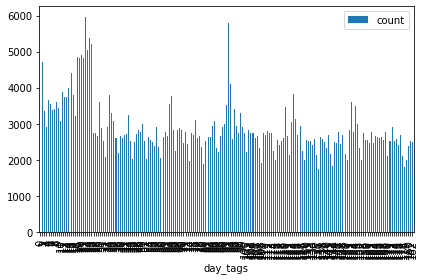

In [17]:
dayWiseTransactionCount = most_frequent_country.groupby("day_tags")["TransactionID"].agg(['count'])
dayWiseTransactionCount.plot.bar()
plt.tight_layout()

## Conclusion ##
As you can see, majority of the transactions were done in the earlier days in the time frame. There are only few outliers (a day or two) in the six month time frame

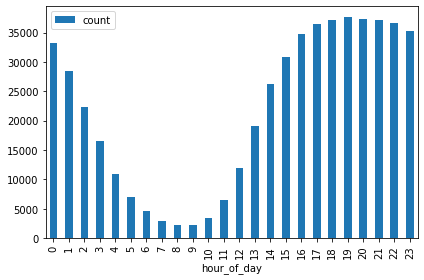

In [18]:
hourWiseTransactionCount = most_frequent_country.groupby("hour_of_day")["TransactionID"].agg(['count'])
hourWiseTransactionCount.plot.bar()
plt.tight_layout()

## Conclusion ##
1. As we can see in the above plot, that a majority of transactions are calculated in hours (hour 0 to hour 2) and in late hours (hour 15 to hour 23).
2. This indicates majority of the people who reside in country with code 87, have their waking hours as per base reference, from hour 0 to hour 4 and hour 13 to hour 23. So waking hours of people in country code 87, lies in ranges [13, 23], [0, 4]

## Part 3 - Product Code

In [20]:
# TODO: code to analyze prices for different product codes
basic_fields_df.ProductCD.value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [157]:
product_agg_df = basic_fields_df.groupby(["ProductCD"])["TransactionID", "TransactionAmt"].agg(["min", "max", "count"])
product_agg_df.columns = ["_".join(x) for x in product_agg_df.columns.ravel()] # normalizing hierarchical column names
product_agg_df

,TransactionID_min,TransactionID_max,TransactionID_count,TransactionAmt_min,TransactionAmt_max,TransactionAmt_count
ProductCD,,,,,,
C,2987010,3577534,68519,0.251,712.896,68519
H,2987004,3577506,33024,15.000,500.000,33024
R,2987099,3577531,37699,25.000,1800.000,37699
S,2987038,3577184,11628,5.000,1550.000,11628
W,2987000,3577539,439670,1.000,31937.391,439670


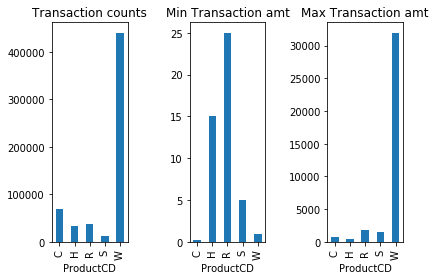

In [ ]:
figure, axes = plt.subplots(1,3)

product_agg_df["TransactionID_count"].plot.bar(ax=axes[0])
product_agg_df["TransactionAmt_min"].plot.bar(ax=axes[1])
product_agg_df["TransactionAmt_max"].plot.bar(ax=axes[2])


axes[0].set_title("Transaction counts")
# axes[0].title.set_size(10)
axes[1].set_title("Min Transaction amt")
# axes[1].title.set_size(10)
axes[2].set_title("Max Transaction amt")
# axes[2].title.set_size(10)
# axes[1].set_title("non_fraud")
# plt.subplot(1,0, 0)

plt.tight_layout()

## Conclusion ##


1.   Product W is the product which is bought the most indicating  it has more demand, thus more price. This is confirmed by the max amount for Product W, which is highest among its peers
2.   Product C has more balance stats. Its' transaction counts are not high yet it's max transaction as well as min transaction amount is lower than its peer. 
3.   Product C is cheapest
4.   Same argument for product W, it's most expensive, it's highly demanded as well as its price is high compared to its peers



Write your answer here

## Part 4 - Correlation Coefficient

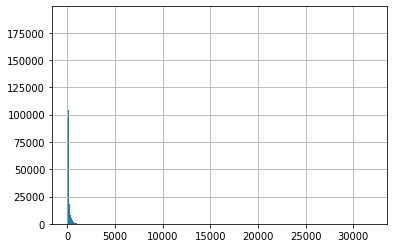

In [22]:
basic_fields_df["TransactionAmt"].hist(bins=1000)

Since, the TransactionAmt is a highly skewed signal, we will use natural logarithm of the field to understand it's nature with other signals 

In [23]:
basic_fields_df["TransactionAmtLog"] = np.log(basic_fields_df["TransactionAmt"])
basic_fields_df["hour_of_day_log"] = np.log(basic_fields_df["hour_of_day"])
basic_fields_df["minute_of_day_log"] = np.log(basic_fields_df["minute_of_day"])

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ip

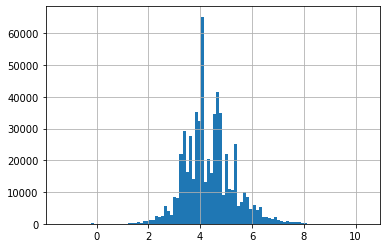

In [24]:
basic_fields_df["TransactionAmtLog"].hist(bins=100)

### Citation ###
https://stats.stackexchange.com/questions/127121/do-logs-modify-the-correlation-between-two-variables

In [25]:
# TODO: code to calculate correlation coefficient
amountVsTime = basic_fields_df[["hour_of_day", "hour_of_day_log", "minute_of_day", "minute_of_day_log", "TransactionAmt", "TransactionAmtLog"]].corr()
amountVsTime

,day_tags,hour_of_day,hour_of_day_log,minute_of_day,minute_of_day_log,TransactionAmt,TransactionAmtLog
day_tags,1.000000,0.005936,0.015907,0.005884,0.010057,0.011656,0.002219
hour_of_day,0.005936,1.000000,0.947394,0.999287,0.900773,0.044526,0.062019
hour_of_day_log,0.015907,0.947394,1.000000,0.946858,0.996571,0.047206,0.067163
minute_of_day,0.005884,0.999287,0.946858,1.000000,0.902921,0.044565,0.062038
minute_of_day_log,0.010057,0.900773,0.996571,0.902921,1.000000,0.039788,0.056623
TransactionAmt,0.011656,0.044526,0.047206,0.044565,0.039788,1.000000,0.701519
TransactionAmtLog,0.002219,0.062019,0.067163,0.062038,0.056623,0.701519,1.000000


In [33]:
basic_fields_df[["hour_of_day", "hour_of_day_log", "minute_of_day", "minute_of_day_log", "TransactionAmt", "TransactionAmtLog"]].corr(method='spearman')

,hour_of_day,hour_of_day_log,minute_of_day,minute_of_day_log,TransactionAmt,TransactionAmtLog
hour_of_day,1.000000,1.000000,0.998190,0.998191,0.038325,0.038325
hour_of_day_log,1.000000,1.000000,0.997953,0.997953,0.034320,0.034320
minute_of_day,0.998190,0.997953,1.000000,1.000000,0.038098,0.038098
minute_of_day_log,0.998191,0.997953,1.000000,1.000000,0.038111,0.038111
TransactionAmt,0.038325,0.034320,0.038098,0.038111,1.000000,1.000000
TransactionAmtLog,0.038325,0.034320,0.038098,0.038111,1.000000,1.000000


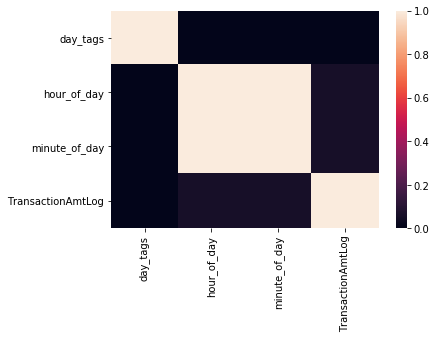

In [20]:
sns.heatmap(amountVsTime)

## Part 5 - Interesting Plot

In [100]:
# TODO: code to generate the plot here.

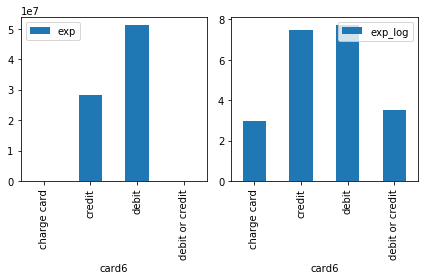

In [187]:
expenses = basic_fields_df.groupby(['card6'])['TransactionAmt'].agg(['sum'])
expenses = expenses.rename(columns={"sum": "exp"})

expenses['exp_log'] = np.log10(expenses['exp'])

figure, axes = plt.subplots(1,2)
expenses.plot.bar(ax=axes[0], y='exp')
expenses.plot.bar(ax=axes[1], y='exp_log')

plt.tight_layout()

# Conclusion (Insight) #
1.  As you can notice that, most expenses are done through debit card followed by credit card. The least expenses are done through change card
2.  This indicates that people prefer to stay under limit and not exceed their credit limit, else they will have to penalty charges. Possibly fear of penalty charges drive people to use less or avoid using credit card for major expenses.
3.  Also, the minimal expenses on change card indicate that people rarely pay through cash to get a change card back. Most of the transactions carried out by people (regardless whether they are fraudsters or innocuous) are cash-less

In [188]:
b = basic_fields_df.groupby(['addr2', 'card6'])['TransactionID'].agg(['count'])
b = b.unstack(level=-1)
b.head()

count                             
card6 charge card credit debit debit or credit
addr2                                         
10.0          NaN    7.0   1.0             NaN
13.0          NaN    5.0   2.0             NaN
14.0          NaN    1.0   NaN             NaN
15.0          NaN    1.0   NaN             NaN
16.0          2.0   46.0   7.0             NaN

In [189]:
basic_fields_df.card6.value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [190]:
basic_fields_df.card4.value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

Write your answer here

## Part 6 - Prediction Model

In [ ]:
# TODO: code for your final model

## Checking Duplicates across whole data-set
Testing whether there are any duplicates in the base data (TransactionID, DeviceType, DeviceInfo, TransactionDT, TransactionAmt, ProductCD, addr1, addr2, dist1, dist2, card4, card6, P_emaildomain, R_emaildomain) of transactions and devices.

---

Found that there are no duplicates since shape on `base_df[base_duplicates]` responds with 0 count against number of rows


In [161]:
base_duplicates = basic_fields_df.duplicated()
print("Number of duplicates in base fields: " + str(basic_fields_df[base_duplicates].shape[0]))

Number of duplicates in base fields: 0


Write your answer here

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: FILL HERE

Highest Rank: FILL HERE

Score: FILL HERE

Number of entries: FILL HERE

INCLUDE IMAGE OF YOUR KAGGLE RANKING